# Twitter Sentiment Analysis using Machine Learning Approaches 

## Introduction:
Numerous industries are going though technological transformations that requires a need to handle unstructured data as well. But the biggest challenge here is to make use of this data and turn it into useful insights that could add value to company at the end. In this era of social media, it somehow easy and complex at the same time to know performance of the products, user feedback and in turn improve them. This could be done through sentiment analysis. By use of sentiment analysis any business can turn the data into tangible intelligence that can drive change.  

## Probelm Statement 
Twitter is a popular social microblogging app where users have full independence to express their opinions about products, topics, individuals etc. This is done in the form of tweets. In this project we will try to implement Sentiment140 dataset created by Stanford University into positive or negative sentiments using multiple ML approaches.  

## Dataset 
Dataset is publicly available for academics on the Stanford repository. It was created using Twitter API which helps to retrieve tweets using a query. It is of csv format with following specifications:
It contain 160000 tweets and contain 6 attribute fields.
1.	Polarity of tweet (negative, positive, or neutral)
2.	Id of the tweet
3.	Date of tweet
4.	Query
5.	The user that tweeted 
6.	Text of the tweet 

Among all only the polarity and text attributes are of our interest. We will drop rest of the columns, and this is done in data analysis part of the project.  

## Outline
1.	Imports
2.	Data Analysis
3.	Pre-Processing
4.	Encoding 
5.	Training and Evaluation 



# Imports

**Libraries**

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
import string
import re
import numpy as np
from nltk.corpus import stopwords

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

**Dataset**

In [ ]:
import os
import zipfile
import urllib.request
# ZZ: unzip directly in colab without mounting a drive
url = "http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip"

tb_path = os.path.join(os.getcwd(),"Dataset")
tb_zip = os.path.join(os.getcwd(),"Dataset", "trainingandtestdata.zip")

if not os.path.exists(tb_path):
    os.makedirs(tb_path)

if not os.path.exists(tb_zip):
    urllib.request.urlretrieve(url, tb_zip)
    print("Successful download")

with zipfile.ZipFile(tb_zip, 'r') as zip_ref:
    zip_ref.extractall(path=tb_path)
    print("Successful extraction")

Successful download
Successful extraction


In [ ]:
cd /content/Dataset/

/content/Dataset


Converting into data frame. Both **train** and **test** set are provided by the Stanford research department and columns are labelled according to information provided in their research paper and official website of the project.  

In [ ]:
cols = ['polarity','id','date','query','user','text']
data = pd.read_csv('training.1600000.processed.noemoticon.csv', header=None, encoding='latin-1', names=cols)  
test_data = pd.read_csv('testdata.manual.2009.06.14.csv', header=None, encoding='latin-1', names=cols)

# Data Analysis

Analysing the **train dataset** [it contains 160000 rows(tweets) and 6 columns(features/attributes)]

In [ ]:
#A slight analysis of dataframe
print("-------------------Train Set--------------------")
print("Dataframe structure:")
print(data)
print()

#alternate way for checking the dimensions of the datset
#data.shape

-------------------Train Set--------------------
Dataframe structure:
         polarity  ...                                               text
0               0  ...  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1               0  ...  is upset that he can't update his Facebook by ...
2               0  ...  @Kenichan I dived many times for the ball. Man...
3               0  ...    my whole body feels itchy and like its on fire 
4               0  ...  @nationwideclass no, it's not behaving at all....
...           ...  ...                                                ...
1599995         4  ...  Just woke up. Having no school is the best fee...
1599996         4  ...  TheWDB.com - Very cool to hear old Walt interv...
1599997         4  ...  Are you ready for your MoJo Makeover? Ask me f...
1599998         4  ...  Happy 38th Birthday to my boo of alll time!!! ...
1599999         4  ...  happy #charitytuesday @theNSPCC @SparksCharity...

[1600000 rows x 6 columns]



Analysing the **test dataset** [it contains 498 rows(tweets) and 6 columns(features/attributes)]

In [ ]:
#A slight analysis of dataframe 
print("-------------------Train Set--------------------")
print("Dataframe structure:")
print(test_data)
print()


-------------------Train Set--------------------
Dataframe structure:
     polarity  ...                                               text
0           4  ...  @stellargirl I loooooooovvvvvveee my Kindle2. ...
1           4  ...  Reading my kindle2...  Love it... Lee childs i...
2           4  ...  Ok, first assesment of the #kindle2 ...it fuck...
3           4  ...  @kenburbary You'll love your Kindle2. I've had...
4           4  ...  @mikefish  Fair enough. But i have the Kindle2...
..        ...  ...                                                ...
493         2  ...  Ask Programming: LaTeX or InDesign?: submitted...
494         0  ...  On that note, I hate Word. I hate Pages. I hat...
495         4  ...  Ahhh... back in a *real* text editing environm...
496         0  ...  Trouble in Iran, I see. Hmm. Iran. Iran so far...
497         0  ...  Reading the tweets coming out of Iran... The w...

[498 rows x 6 columns]



Checking for **null** values

In [ ]:
#checking if our test or train data contains any null values
data.isnull().any(), test_data.isnull().any()

(polarity    False
 id          False
 date        False
 query       False
 user        False
 text        False
 dtype: bool, polarity    False
 id          False
 date        False
 query       False
 user        False
 text        False
 dtype: bool)

##Plotting

Plotting the distribution of **training and test** data. This visualization helps us to identify if our dataset is well balanced or not. Because based on this we will define our evaluation metrics for training models at the end. The visualization here shows that dataset is well balanced with 80,000 tweets with negative and 80,000 tweets with positive sentiment. 

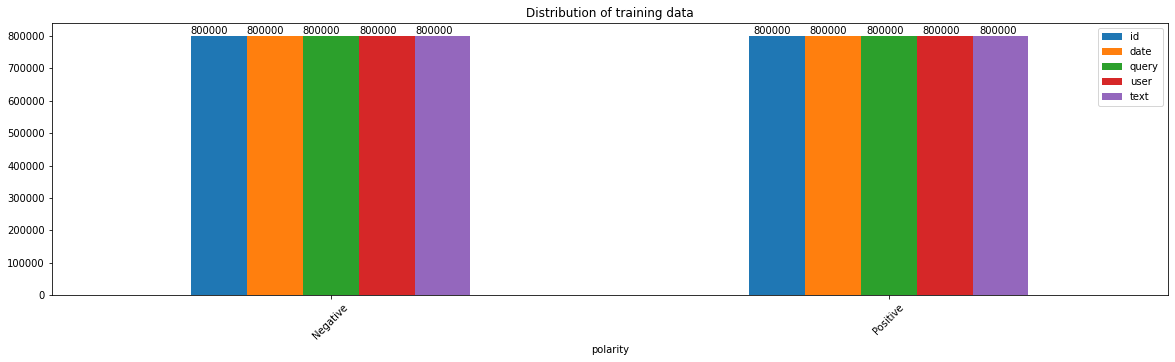

In [ ]:
# Plotting the distribution for training dataset.
plot = data.groupby('polarity').count().plot(kind='bar', title='Distribution of training data',legend=True,figsize=(20, 5))
plot.set_xticklabels(['Negative','Positive'], rotation=45)
for p in plot.patches:
    plot.annotate(str(p.get_height()), (p.get_x() * 1.01 , p.get_height() * 1.01))
# Storing data in lists.
text, sentiment = list(data['text']), list(data['polarity'])

We note that there is an ambiguity in **test set** since we are interested in only two classes positive and negative. Therefore, we need to check the unique classes and do a bit of pre processing. Class with label **2** is what we don't need becuase it contains neutral sentiment. 

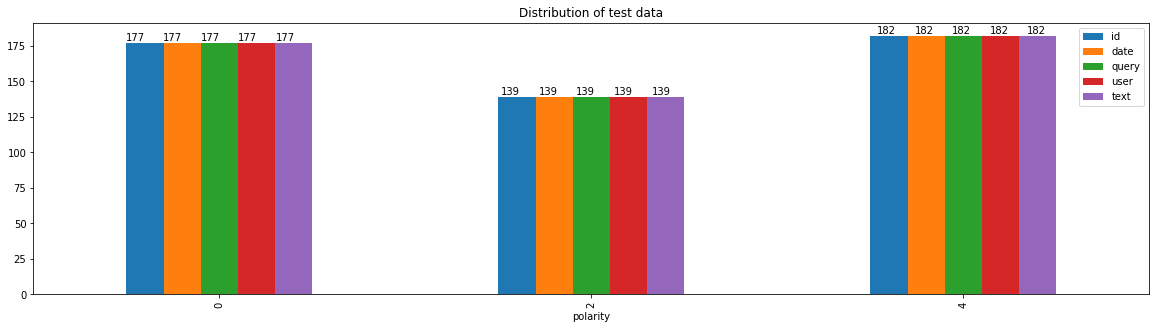

In [ ]:
plot = test_data.groupby('polarity').count().plot(kind='bar', title='Distribution of test data',legend=True,figsize=(20, 5))
for p in plot.patches:
    plot.annotate(str(p.get_height()), (p.get_x() * 1.01 , p.get_height() * 1.01))

text, sentiment = list(data['text']), list(data['polarity'])

In [ ]:
#Using only two col because rest are useless for our task
data = data[['polarity','text']]
test_data = test_data[['polarity','text']]

In [ ]:
#number of classes (positive, negative, neutral) 
data['polarity'].nunique(), test_data['polarity'].nunique()

(2, 3)

In [ ]:
# 0 = negative, 4 = positive, 2 = neutral class
data['polarity'].unique(), test_data['polarity'].unique()

(array([0, 4]), array([4, 0, 2]))

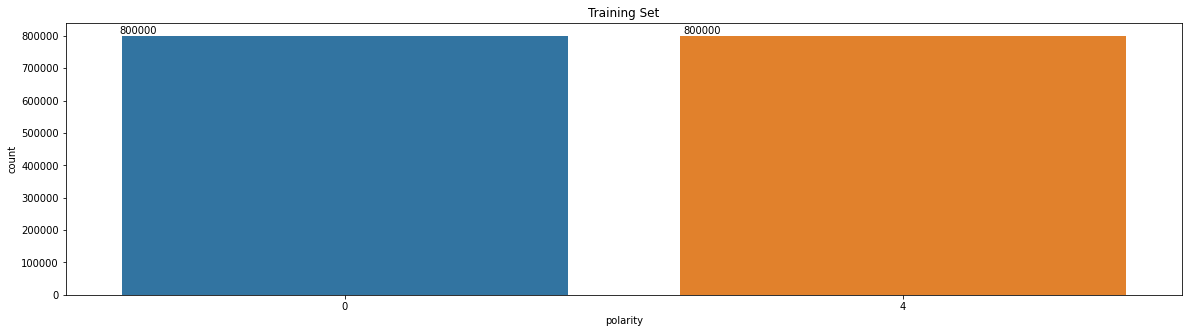

In [ ]:
# distribution of our selected columns in train set
plt.figure(figsize = (20,5))
plt.title('Training Set')
plot=sns.countplot(x='polarity', data=data)
for p in plot.patches:
    plot.annotate(str(p.get_height()), (p.get_x() * 1.01 , p.get_height() * 1.01))

Since we are not interested in **neutral class**. Therefore, we do not consider it in **test set**.

In [ ]:
test_data = test_data[(test_data['polarity']==0) | (test_data['polarity']==4)]

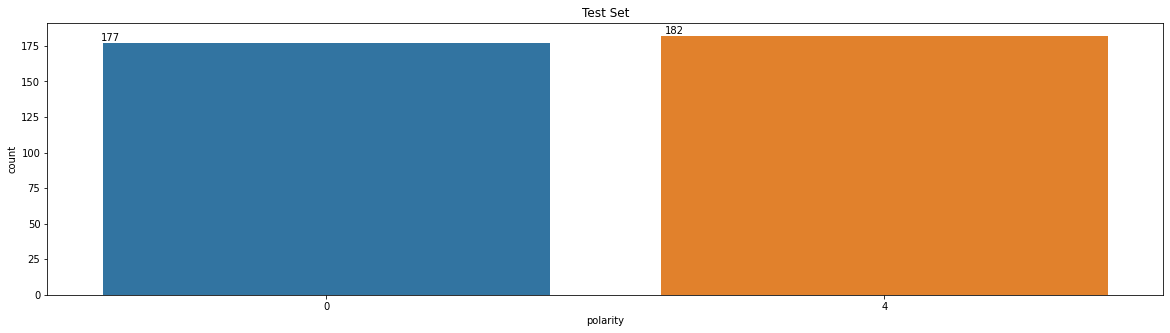

In [ ]:
# distribution of our selected columns in test set without neutral class
plt.figure(figsize = (20,5))
plt.title('Test Set')
ax=sns.countplot(x='polarity', data=test_data)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.01 , p.get_height() * 1.01))

Naming the positive class as 1 instead of 4 for our convenience.

In [ ]:
data['polarity'] = data['polarity'].replace(4,1)
test_data['polarity'] = test_data['polarity'].replace(4,1)

In [ ]:
#a quick for confirmation 
data['polarity'].unique(), test_data['polarity'].unique()

(array([0, 1]), array([1, 0]))

## Word Cloud
Visualizing the words frequency in our dataset using Word Cloud. It is an informal representation of frequency but still it gives some insights. Bigger words mean more occurrence and small words means less occurrence.  

**Negative Class**

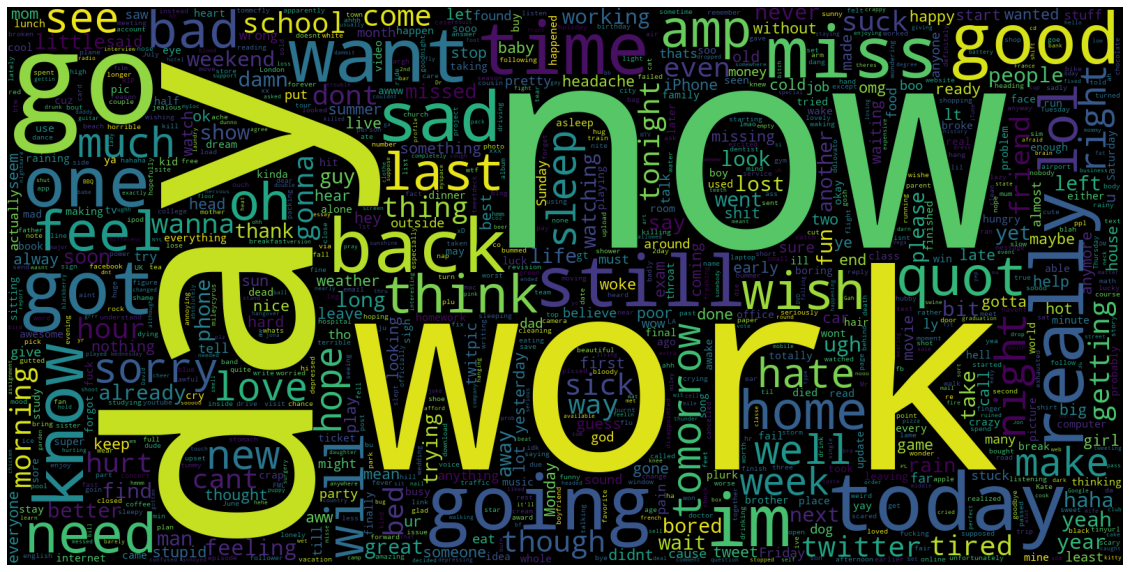

In [ ]:
data_neg = data[data['polarity']==0]['text']
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.figure(figsize = (20,20))
plt.axis('off')
plt.imshow(wc);

**Positive Class**

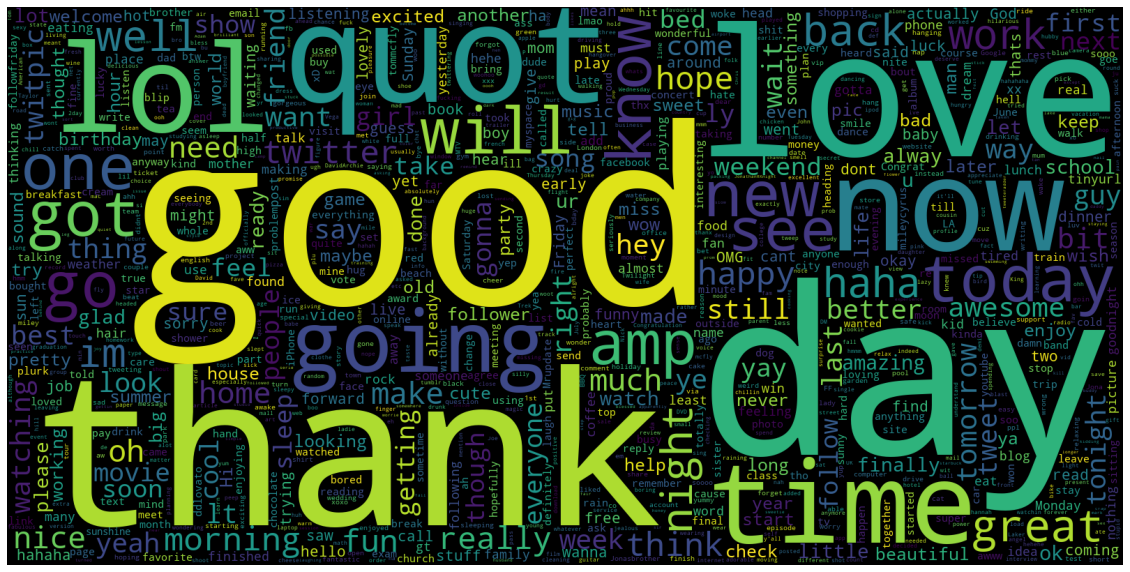

In [ ]:
data_pos = data[data['polarity']==1]['text']
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.axis('off')
plt.imshow(wc);

# Training

First, we will try to train our model without any sort of pre-processing. This will help us to compare different models based on their difference in representation of data. It is very import step to compare our model against overfitting. 

In [ ]:
#splitting data for training and validation part
X=data.text
y=data.polarity
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state =42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1120000,), (480000,), (1120000,), (480000,))

In [ ]:
#test data set
test_class = test_data['polarity']
test_tweet = test_data['text']
test_tweet.shape, test_class.shape 

((359,), (359,))

**Encoding**

**Tf-Idf**

Term frequency and Inverse document frequency (Tf-Idf):

wrs = No. of rep of words in sentence

ws = No. of words in sentence

**Tf** = $\frac{wrs}{ws}$ 

s = No. of Sentence

sw = No. of sentences containing words

**IDF** = log $\frac{s}{sw}$

Here we get some semantic information about the sentence. Importance is given to the words in sentences. This converts the data into numerical format represented by matrix. 


In [ ]:
vectoriser = TfidfVectorizer(max_features=50000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

No. of feature_words:  50000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
test_tweet  = vectoriser.transform(test_tweet)

**Baseline Classifier**

Before training on real classifiers, we need a baseline. This will give us an idea or a baseline that our classifiers should achieve. 

In [ ]:
from sklearn.dummy import DummyClassifier

rnd_classifier = DummyClassifier(strategy='uniform')

rnd_classifier.fit(X_train, y_train)


DummyClassifier(strategy='uniform')

**Evaluation Functions**

Let's first define functions that would evaluate our models on validation and test set

In [ ]:
def model_Evaluate(model):
    # Predict values for validation dataset
    y_pred = model.predict(X_test)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1} : {v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

In [ ]:
def model_Evaluatetest(model):
    # Predict values for Test dataset
    y_pred = model.predict(test_tweet)
    print(classification_report(test_class, y_pred))
    cf_matrix = confusion_matrix(test_class, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1} : {v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Test - Confusion Matrix", fontdict = {'size':18}, pad = 20)

Evaluating our **DUMMY CLASSIFIER**

For example, in this case we have 50% of accuracy, now any classifier we train should get more than 50% because it is achieved even by a dummy classifier.  

              precision    recall  f1-score   support

           0       0.50      0.50      0.50    239361
           1       0.50      0.50      0.50    240639

    accuracy                           0.50    480000
   macro avg       0.50      0.50      0.50    480000
weighted avg       0.50      0.50      0.50    480000



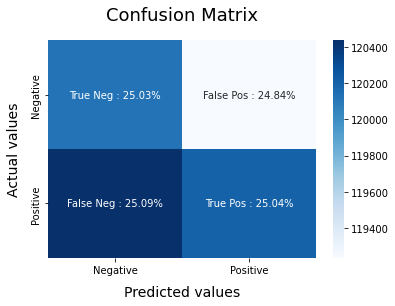

In [ ]:
model_Evaluate(rnd_classifier)

**Training**

Now we will train it on Naïve Bayes, Support Vector Machines and Logistic Regression. And we will compare their performance with pre processed data. At the end we will have a best classifier either from pre-processed data or unprocessed data based on metrics we defined below. 

**Naive Byaes**

              precision    recall  f1-score   support

           0       0.78      0.78      0.78    239361
           1       0.78      0.78      0.78    240639

    accuracy                           0.78    480000
   macro avg       0.78      0.78      0.78    480000
weighted avg       0.78      0.78      0.78    480000



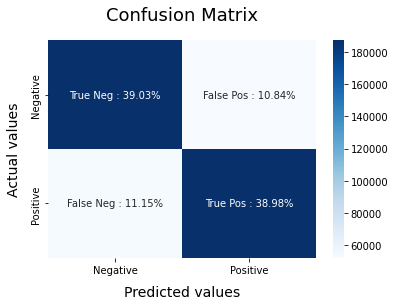

In [ ]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

**Test Data**

              precision    recall  f1-score   support

           0       0.80      0.82      0.81       177
           1       0.82      0.80      0.81       182

    accuracy                           0.81       359
   macro avg       0.81      0.81      0.81       359
weighted avg       0.81      0.81      0.81       359



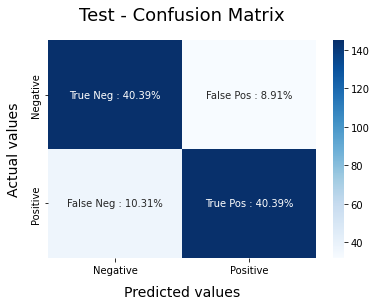

In [ ]:
model_Evaluatetest(BNBmodel)

**Linear Support Vector Machine**

              precision    recall  f1-score   support

           0       0.80      0.79      0.79    239361
           1       0.79      0.81      0.80    240639

    accuracy                           0.80    480000
   macro avg       0.80      0.80      0.80    480000
weighted avg       0.80      0.80      0.80    480000



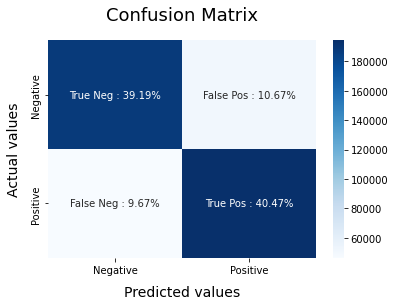

In [ ]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

**Test Data**

              precision    recall  f1-score   support

           0       0.82      0.76      0.79       177
           1       0.78      0.84      0.81       182

    accuracy                           0.80       359
   macro avg       0.80      0.80      0.80       359
weighted avg       0.80      0.80      0.80       359



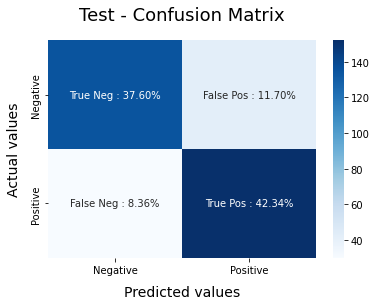

In [ ]:
model_Evaluatetest(SVCmodel)

**Logistic Regression**

              precision    recall  f1-score   support

           0       0.81      0.79      0.80    239361
           1       0.80      0.81      0.80    240639

    accuracy                           0.80    480000
   macro avg       0.80      0.80      0.80    480000
weighted avg       0.80      0.80      0.80    480000



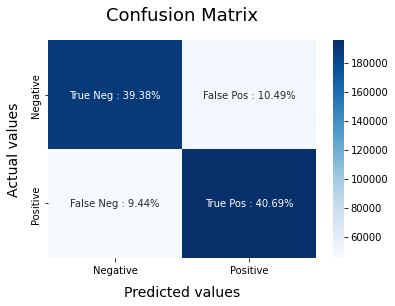

In [ ]:
LRmodel = LogisticRegression(max_iter = 1000)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)

**Test Data**

              precision    recall  f1-score   support

           0       0.83      0.80      0.82       177
           1       0.81      0.84      0.83       182

    accuracy                           0.82       359
   macro avg       0.82      0.82      0.82       359
weighted avg       0.82      0.82      0.82       359



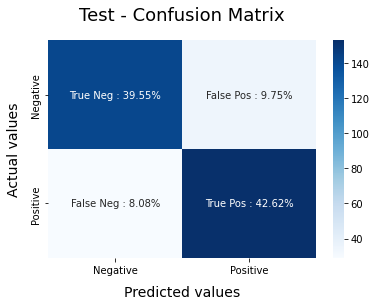

In [ ]:
model_Evaluatetest(LRmodel)

**Metrics**

Since, out dataset was well balanced. We can rely to evaluate our classifier based on accuracy as well. Therefore, our metric for comparison would be accuracy only. But still we have a view of confusion matrix, precision, Recall and f1-measure. 

Below is the comparison of performance of our three classifiers without pre processing. According to it **Logistic Regression** performed best in terms of Accuracy. 

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
NB_pred = BNBmodel.predict(test_tweet)
SVM_pred = SVCmodel.predict(test_tweet)
LR_pred = LRmodel.predict(test_tweet)

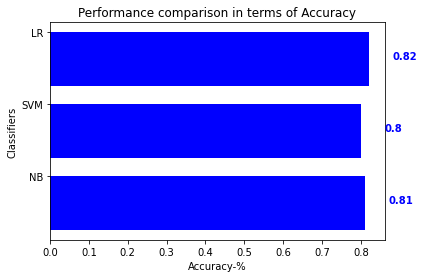

In [ ]:
x = ['NB','SVM','LR']
y = [round(accuracy_score(NB_pred, test_class),2),round(accuracy_score(SVM_pred, test_class),2),round(accuracy_score(LR_pred, test_class),2)]

fig, ax = plt.subplots()    
width = 0.75 # the width of the bars 
ind = np.arange(len(y))  # the x locations for the groups
for i, v in enumerate(y):
    ax.text(v+0.06, i, str(v), color='blue', fontweight='bold')
ax.barh(ind, y, width, color="blue")
ax.set_yticks(ind+width/2)
ax.set_yticklabels(x, minor=False)
plt.title('Performance comparison in terms of Accuracy')
plt.xlabel('Accuracy-%')
plt.ylabel('Classifiers')      
plt.show()


#Data Pre-Processing 
Since our dataset contains hyperlinks, usernames, puntuation symbols, spelling mistakes, stop words, numeric characters etc. We can pre process them to clean our data and see if our classifiers perform better then before or even worst.

The reserach paper that we are following suggest cleaning of **repetative characters**, **usernames** and **hyperlinks**. We will start by it keep it as a base. We will use regular expressions (regex patterns) for this purpose. 

**URL**

In [ ]:
#this should always be done before removing puntuations from text
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+) |(http[^s]+))',' ',data)
data['text'] = data['text'].apply(lambda x: cleaning_URLs(x))
data['text'].head()

0    @switchfoot  that's a bummer.  You shoulda got...
1    is upset that he can't update his Facebook by ...
2    @Kenichan I dived many times for the ball. Man...
3      my whole body feels itchy and like its on fire 
4    @nationwideclass no, it's not behaving at all....
Name: text, dtype: object

**Username**

In [ ]:
#this should always be done before removing puntuations from text
def cleaning_Username(data):
    return re.sub('@[^\s]+',' ',data)
data['text'] = data['text'].apply(lambda x: cleaning_Username(x))
data['text'].head()

0       that's a bummer.  You shoulda got David Car...
1    is upset that he can't update his Facebook by ...
2      I dived many times for the ball. Managed to ...
3      my whole body feels itchy and like its on fire 
4      no, it's not behaving at all. i'm mad. why a...
Name: text, dtype: object

**Repeating characters**

In [ ]:
#cleaning the words with repetative characters upto a limit of maximum 2. e.g bummmer would become bumer but bummer would not be changed 
def cleaning_repeating_char(text):
    return re.sub('(.)\1{2,}','$1', text)
data['text'] = data['text'].apply(lambda x: cleaning_repeating_char(x))
data['text'].head()

0       that's a bummer.  You shoulda got David Car...
1    is upset that he can't update his Facebook by ...
2      I dived many times for the ball. Managed to ...
3      my whole body feels itchy and like its on fire 
4      no, it's not behaving at all. i'm mad. why a...
Name: text, dtype: object

**It is very important to run train split and evaluation functions again if we are executing this part of notebook after the one without pre processing.**


In [ ]:
'''X=data.text
y=data.polarity
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state =42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape'''

In [ ]:
'''X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
test_tweet  = vectoriser.transform(test_tweet)'''

N-grams are consecutive words in a sentence. We use **bi-gram** along our vectorizor because according to the paper it would improve performance of the classifier.

In [ ]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=50000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

No. of feature_words:  50000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
test_tweet  = vectoriser.transform(test_tweet)

**Naive Bayes**

              precision    recall  f1-score   support

           0       0.80      0.77      0.78    239361
           1       0.78      0.81      0.79    240639

    accuracy                           0.79    480000
   macro avg       0.79      0.79      0.79    480000
weighted avg       0.79      0.79      0.79    480000



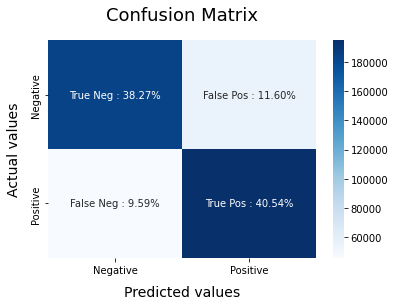

In [ ]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

**Test Data**

              precision    recall  f1-score   support

           0       0.83      0.79      0.81       177
           1       0.80      0.84      0.82       182

    accuracy                           0.81       359
   macro avg       0.81      0.81      0.81       359
weighted avg       0.81      0.81      0.81       359



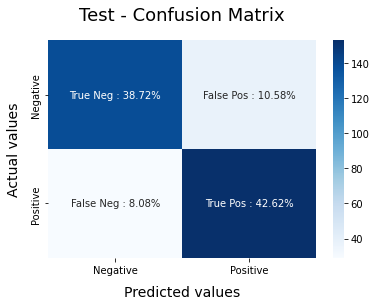

In [ ]:
model_Evaluatetest(BNBmodel)

**Support Vector Machine**

              precision    recall  f1-score   support

           0       0.82      0.80      0.81    239361
           1       0.81      0.83      0.82    240639

    accuracy                           0.81    480000
   macro avg       0.81      0.81      0.81    480000
weighted avg       0.81      0.81      0.81    480000



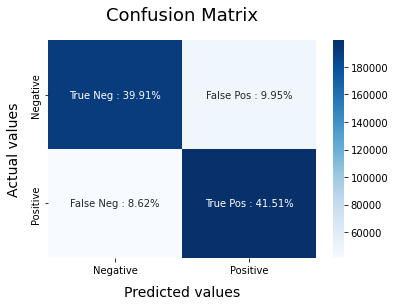

In [ ]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

**Test Data**

              precision    recall  f1-score   support

           0       0.84      0.81      0.82       177
           1       0.82      0.85      0.83       182

    accuracy                           0.83       359
   macro avg       0.83      0.83      0.83       359
weighted avg       0.83      0.83      0.83       359



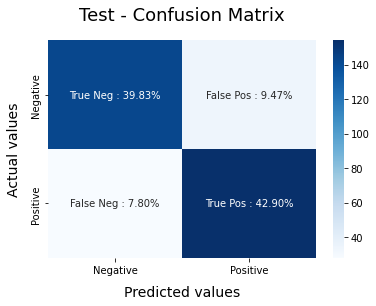

In [ ]:
model_Evaluatetest(SVCmodel)

**Logistic Regression**

              precision    recall  f1-score   support

           0       0.82      0.81      0.81    239361
           1       0.81      0.83      0.82    240639

    accuracy                           0.82    480000
   macro avg       0.82      0.82      0.82    480000
weighted avg       0.82      0.82      0.82    480000



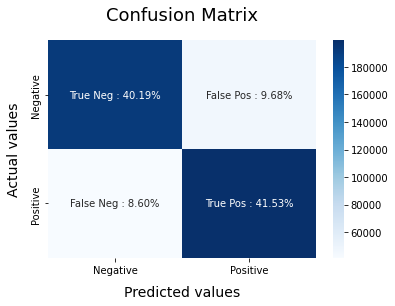

In [ ]:
LRmodel = LogisticRegression(max_iter = 1000)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)

**Test Data**

              precision    recall  f1-score   support

           0       0.84      0.78      0.81       177
           1       0.80      0.85      0.82       182

    accuracy                           0.82       359
   macro avg       0.82      0.82      0.82       359
weighted avg       0.82      0.82      0.82       359



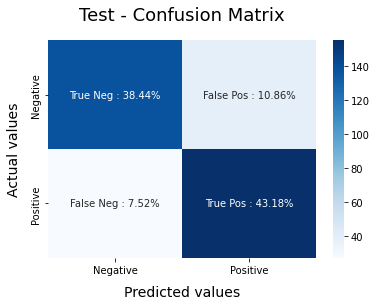

In [ ]:
model_Evaluatetest(LRmodel)

**Evaluation**

In [ ]:
NB_pred = BNBmodel.predict(test_tweet)
SVM_pred = SVCmodel.predict(test_tweet)
LR_pred = LRmodel.predict(test_tweet)

We could see that there is a **significant inrease in the accuracy of SVM after pre processing** while other two classifiers nearly performed the same on test set. 

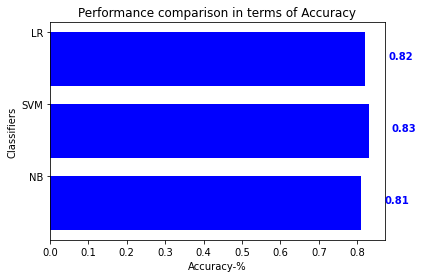

In [ ]:
x = ['NB','SVM','LR']
y = [round(accuracy_score(NB_pred, test_class),2),round(accuracy_score(SVM_pred, test_class),2),round(accuracy_score(LR_pred, test_class),2)]

fig, ax = plt.subplots()    
width = 0.75 # the width of the bars 
ind = np.arange(len(y))  # the x locations for the groups
for i, v in enumerate(y):
    ax.text(v+0.06, i, str(v), color='blue', fontweight='bold')
ax.barh(ind, y, width, color="blue")
ax.set_yticks(ind+width/2)
ax.set_yticklabels(x, minor=False)
plt.title('Performance comparison in terms of Accuracy')
plt.xlabel('Accuracy-%')
plt.ylabel('Classifiers')      
plt.show()

Lastly, we will try to notice what happens if we **remove** **stop words**, **puntuation symbols**, **numeric characters** and do **lemmatization/stemming** to our text. Our goal is to observe the behaviour of our classifier if it's performs better or overfits in that scenario. 

**Stop Words**

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
STOPWORDS=stopwords.words('english')
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
data['text'] = data['text'].apply(lambda text: cleaning_stopwords(text))

data['text'].head()

0    that's bummer. You shoulda got David Carr Thir...
1    upset can't update Facebook texting it... migh...
2    I dived many times ball. Managed save 50% The ...
3                     whole body feels itchy like fire
4    no, behaving all. i'm mad. here? I can't see t...
Name: text, dtype: object

**Numbers**

In [ ]:
#cleaning the tweets from numbers
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
data['text'] = data['text'].apply(lambda x: cleaning_numbers(x))
data['text'].head()

0    that's bummer. You shoulda got David Carr Thir...
1    upset can't update Facebook texting it... migh...
2    I dived many times ball. Managed save % The re...
3                     whole body feels itchy like fire
4    no, behaving all. i'm mad. here? I can't see t...
Name: text, dtype: object

**Puntuation Symbols**

In [ ]:
#cleaning the text from puntuation 
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
data['text']= data['text'].apply(lambda x: cleaning_punctuations(x))
data['text'].head()

0    thats bummer You shoulda got David Carr Third ...
1    upset cant update Facebook texting it might cr...
2    I dived many times ball Managed save  The rest...
3                     whole body feels itchy like fire
4         no behaving all im mad here I cant see there
Name: text, dtype: object

In [ ]:
from nltk.tokenize import word_tokenize,sent_tokenize,WhitespaceTokenizer
tokenizer = WhitespaceTokenizer()

**Stemming**

In [ ]:
#stemming operation 
st = nltk.PorterStemmer()
def stemming_on_text(data):
    return " ".join([st.stem(word) for word in tokenizer.tokenize(str(data))])
data['text']= data['text'].apply(lambda x: stemming_on_text(x))
data['text'].head()

0    that bummer you shoulda got david carr third d...
1    upset cant updat facebook text it might cri re...
2    I dive mani time ball manag save the rest go b...
3                      whole bodi feel itchi like fire
4            no behav all im mad here I cant see there
Name: text, dtype: object

**Lemmatization**

In [ ]:
nltk.download('wordnet')
lm = nltk.stem.WordNetLemmatizer()
def lemmatizer_on_text(data):
    return " ".join([lm.lemmatize(word) for word in tokenizer.tokenize(str(data))])

data['text'] = data['text'].apply(lambda x: lemmatizer_on_text(x))
data['text'].head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0    that bummer you shoulda got david carr third d...
1    upset cant updat facebook text it might cri re...
2    I dive mani time ball manag save the rest go b...
3                      whole bodi feel itchi like fire
4            no behav all im mad here I cant see there
Name: text, dtype: object

**Word Cloud** after pre processing give a slightly better representation of words with respect to their frequency in respected class.

**Negative Class**

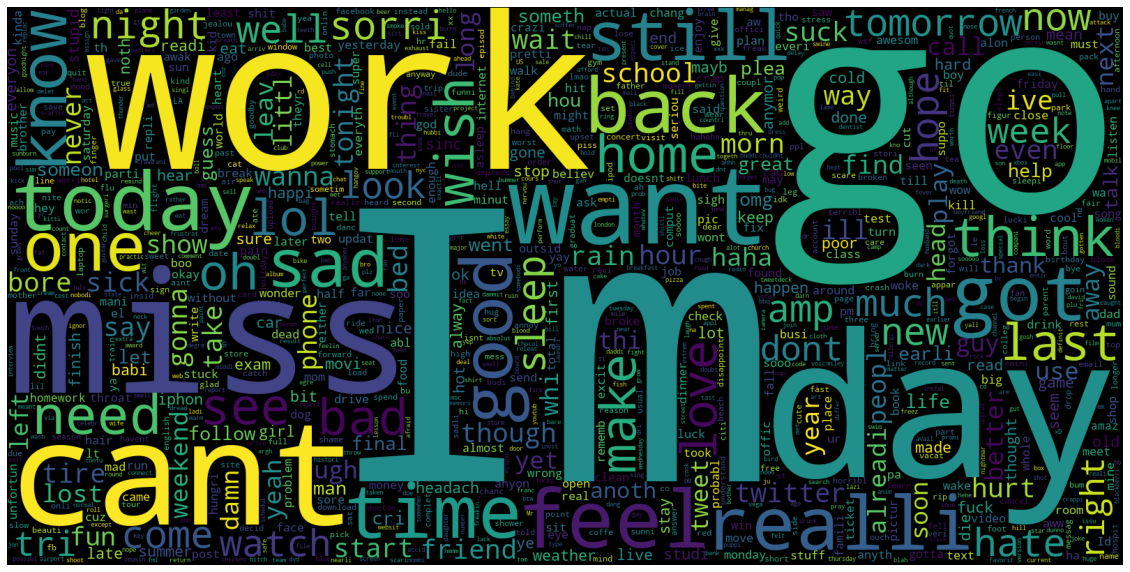

In [ ]:
#negative class
data_neg = data[data['polarity']==0]['text']
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.figure(figsize = (20,20))
plt.axis('off')
plt.imshow(wc);

**Positive Class**

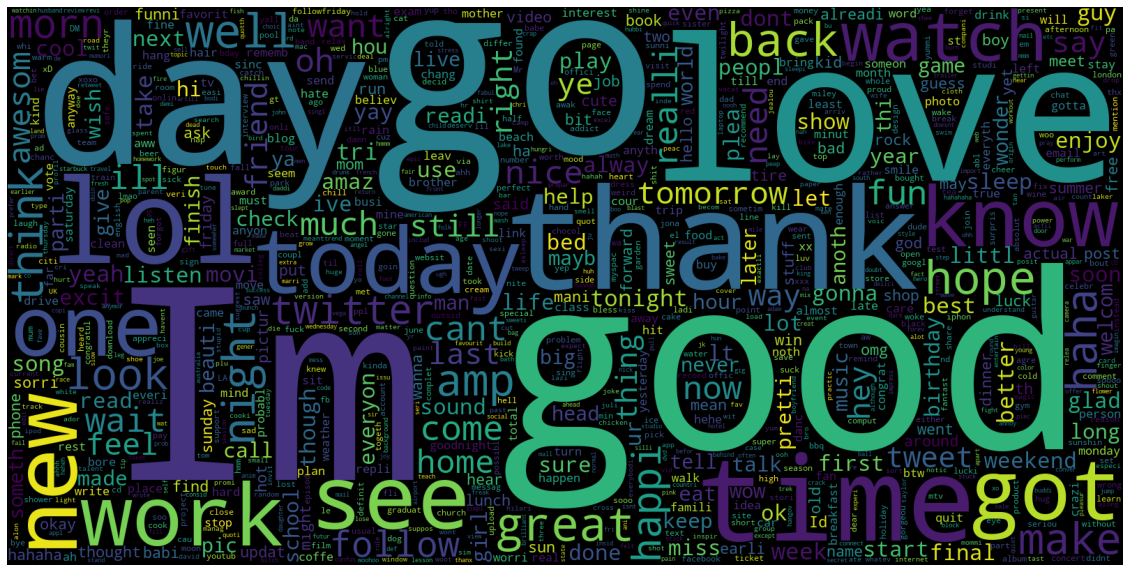

In [ ]:
#positive class
data_pos = data[data['polarity']==1]['text']
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.axis('off')
plt.imshow(wc);

**Naive Bayes**

              precision    recall  f1-score   support

           0       0.79      0.75      0.77    239361
           1       0.76      0.80      0.78    240639

    accuracy                           0.77    480000
   macro avg       0.78      0.77      0.77    480000
weighted avg       0.78      0.77      0.77    480000



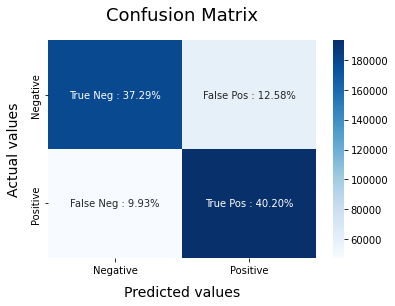

In [ ]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

**Test Data**

              precision    recall  f1-score   support

           0       0.85      0.62      0.72       177
           1       0.71      0.89      0.79       182

    accuracy                           0.76       359
   macro avg       0.78      0.76      0.75       359
weighted avg       0.78      0.76      0.75       359



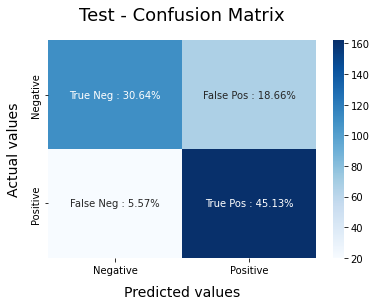

In [ ]:
model_Evaluatetest(BNBmodel)

**Support Vector Machine**

              precision    recall  f1-score   support

           0       0.80      0.76      0.78    239361
           1       0.77      0.81      0.79    240639

    accuracy                           0.79    480000
   macro avg       0.79      0.79      0.79    480000
weighted avg       0.79      0.79      0.79    480000



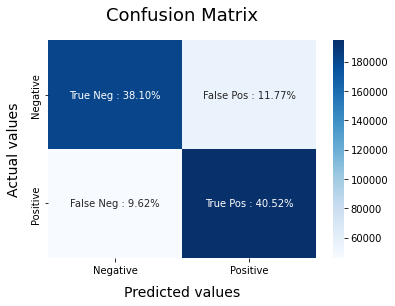

In [ ]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

**Test Data**

              precision    recall  f1-score   support

           0       0.78      0.56      0.65       177
           1       0.66      0.85      0.74       182

    accuracy                           0.70       359
   macro avg       0.72      0.70      0.70       359
weighted avg       0.72      0.70      0.70       359



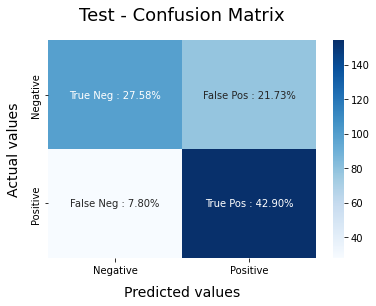

In [ ]:
model_Evaluatetest(SVCmodel)

**Logistic Regression**

              precision    recall  f1-score   support

           0       0.80      0.77      0.79    239361
           1       0.78      0.81      0.80    240639

    accuracy                           0.79    480000
   macro avg       0.79      0.79      0.79    480000
weighted avg       0.79      0.79      0.79    480000



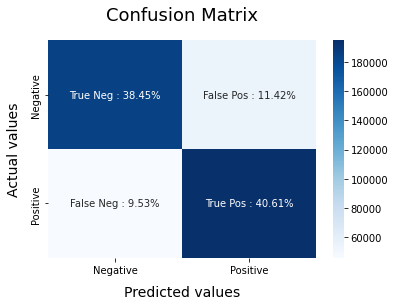

In [ ]:
LRmodel = LogisticRegression(max_iter = 1000)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)

**Test Data**

              precision    recall  f1-score   support

           0       0.81      0.56      0.66       177
           1       0.67      0.87      0.76       182

    accuracy                           0.72       359
   macro avg       0.74      0.72      0.71       359
weighted avg       0.74      0.72      0.71       359



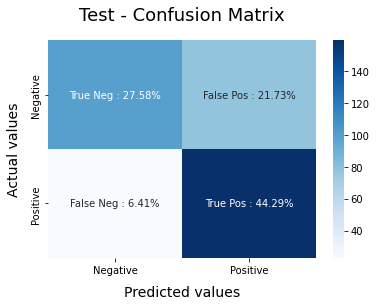

In [ ]:
model_Evaluatetest(LRmodel)

**Evaluation**

In [ ]:
NB_pred = BNBmodel.predict(test_tweet)
SVM_pred = SVCmodel.predict(test_tweet)
LR_pred = LRmodel.predict(test_tweet)

If we see the testing on validation data above we see a decrease in accuracy there as well. This means we have **over processed data hence reduced it's quality** and if we see it's performance on test set. Results are worse becuase we have trained our model on very specific terms hense **overfitted** as well. 

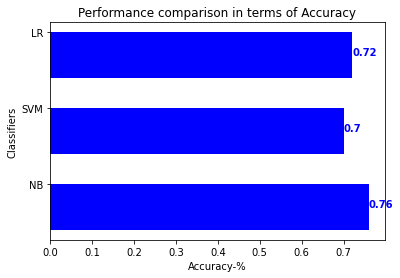

In [ ]:
x = ['NB','SVM','LR']
y = [round(accuracy_score(NB_pred, test_class),2),round(accuracy_score(SVM_pred, test_class),2),round(accuracy_score(LR_pred, test_class),2)]

fig, ax = plt.subplots()    
width = 0.6 # the width of the bars 
ind = np.arange(len(y))  # the x locations for the groups
for i, v in enumerate(y):
    ax.text(v, i, str(v), color='blue', fontweight='bold')
ax.barh(ind, y, width, color="blue")
ax.set_yticks(ind+width/2)
ax.set_yticklabels(x, minor=False)
plt.title('Performance comparison in terms of Accuracy')
plt.xlabel('Accuracy-%')
plt.ylabel('Classifiers')      
plt.show()

#Conclusion

The best results are acheived by pre processing usernames, hyperlinks and repetative characters. Every thing else have worsen the situation. 

Hence, we can conclude that out of 3 models we tested SVM performed best in terms of accuracy (83%) that was our evaluating metric for test data while Naive Bayes was the one with lowest performance but was obviously better then our baseline classifier. 

It is very important when we pre process our data to keep in mind that we should never over process it otherwise we will ultimately end up in bad qulaity dataset. It is as important to avoid as overfitting in Machine Learning Problems. 